In [1]:
''' Vertex Smearing '''

!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

cheated_0 = Events('CheatedRecoFile_0.root')
sliced_0 = f.slice_events(cheated_0)
cheated_0_candidates = f.identify_candidate(cheated_0)
showers_0 = [r[1] for r in cheated_0_candidates if not cheated_0.is_true_track[r[1]]]
print(f'\nThere are {len(showers_0)} candidate showers in cheated_0')

  Using cached uproot-5.5.2-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.7.4-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.5.2-py3-none-any.whl (363 kB)
Using cached awkward-2.7.4-py3-none-any.whl (871 kB)
Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (638 kB)
Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)
Events sliced, 499617 events split across 9505 unique event ids

There are 4767 candidate showers in cheated_0


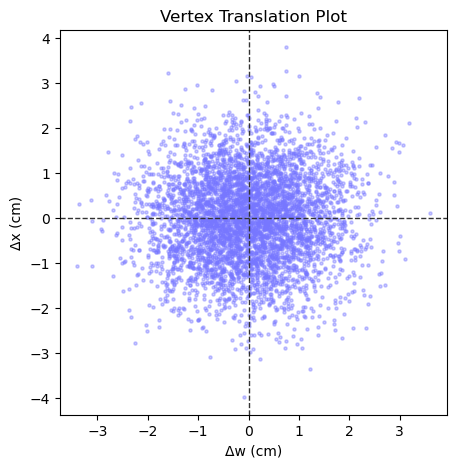

In [9]:
mean = [0, 0]  # Center at (0,0), we need a translation. This is just generating the translation.
cov = [[1, 0], [0, 1]]  # Identity covariance (no correlation)
n_points = len(showers_0)

smears = np.random.multivariate_normal(mean, cov, size=n_points)

plt.figure(figsize = (5,5))
plt.scatter(smears[:, 0], smears[:, 1], alpha=0.4, s=5, c='#77F')
plt.axhline(0, color='#333333', linestyle='--', linewidth=1)
plt.axvline(0, color='#333333', linestyle='--', linewidth=1)
plt.title("Vertex Translation Plot")
plt.xlabel("\u0394w (cm)")
plt.ylabel("\u0394x (cm)")
plt.show()

In [10]:
def get_smears(n_points, width=1, mean=[0, 0], show_plot=False):
    cov = [[width**2, 0], [0, width**2]]  # Identity covariance (no correlation)
    
    smears = np.random.multivariate_normal(mean, cov, size=n_points)

    if show_plot:
        plt.figure(figsize = (5,5))
        plt.scatter(smears[:, 0], smears[:, 1], alpha=0.4, s=5, c='#77F')
        plt.axhline(0, color='#333333', linestyle='--', linewidth=1)
        plt.axvline(0, color='#333333', linestyle='--', linewidth=1)
        plt.title("Vertex Translation Plot")
        plt.xlabel("\u0394w (cm)")
        plt.ylabel("\u0394x (cm)")
        plt.show()

    return smears

def plot_smeared(events, event_idx, smear, debug=False, show_plot=False): # Put debug=True if you want all debug info, same with show_plot
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) <= 15:
        if debug:
            print(f'Event {event_idx} does not meet 15 hit cutoff\n')
        return None

    def debug_print(message):
        if debug:
            print(f"    {message}")
    if debug:
        print(f"Debug for event {event_idx}")

    debug_print(f'Smear Translation: {smear}')
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    adcs = events.reco_adcs_w[event_idx]

    w_vtx_smeared = w_vtx + smear[0]
    x_vtx_smeared = x_vtx + smear[1]

    if show_plot:

        plt.figure(figsize = (10, 8))
        plt.scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
        plt.scatter(w_vtx_smeared, x_vtx_smeared, c='purple', marker='x', s=35, label='Smeared vtx')
        plt.plot([w_vtx, w_vtx_smeared], [x_vtx, x_vtx_smeared], c='b', linewidth=2)
        plt.scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
        plt.title(f'Event Plot; idx: {event_idx}')
        plt.ylabel('X (W View)')
        plt.xlabel('W (Wire Position)')
        plt.legend()
        plt.grid(True)

In [11]:
#smears = get_smears(len(showers_0), 10, show_plot=True)
#plot_smeared(cheated_0, showers_0[4324], smears[4324], debug=True, show_plot=True)

In [12]:
def find_radial_density_increase(x, y, bins=50, center=None, start_radius=0, debug=False, safety_r=5):
    if center is None:
        center = (np.mean(x), np.mean(y))
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    r = r[r > start_radius]
    
    if len(r) == 0:
        return safety_r
    
    r_sorted = np.sort(r)
    
    bin_edges = np.linspace(start_radius, max(r_sorted), bins)
    counts, _ = np.histogram(r_sorted, bins=bin_edges)
    
    areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    densities = counts / areas
    
    diffs = np.diff(densities)
    increase_idx = np.argmax(diffs > 0)
    
    if increase_idx == 0 and diffs[0] <= 0:
        return safety_r
    
    return bin_edges[increase_idx]


def dEdx_smeared(events, event_idx, smear=[0, 0], cone_angle=(2/3)*np.pi, debug=False, show_plot=False): # Put debug=True if you want all debug info, same with show_plot
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) <= 15:
        if debug:
            print(f'Event {event_idx} does not meet 15 hit cutoff\n')
        return None

    def debug_print(message):
        if debug:
            print(f"    {message}")
    if debug:
        print(f"Debug for event {event_idx}")
    
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    w_vtx_smeared = w_vtx + smear[0]
    x_vtx_smeared = x_vtx + smear[1]
    adcs = events.reco_adcs_w[event_idx]
    
    pdg = events.mc_pdg[event_idx]
    c_class = 'lightblue'
    event = 'ERROR: Not e/gamma'
    if pdg in [-11, 11]:
        c_class = '#EEEE00'
        event = 'Electron'
    elif pdg == 22:
        c_class = 'g'
        event = 'Photon'
    debug_print(f'Lepton: {event}')

    if np.sign(np.mean(w_hits) - w_vtx) == -1:
        w_hits = 2 * w_vtx - np.array(w_hits)
        debug_print(f'Event {event_idx} was left-facing, and has been inverted')

    theta_0 = np.arctan2(np.mean(x_hits) - x_vtx, np.mean(w_hits) - w_vtx)
    theta_u = theta_0 + (cone_angle/2)
    theta_l = theta_0 - (cone_angle/2)
    debug_print(f'Angle info:\n        Yaw = {np.degrees(theta_0):.2f}° from +w\n        Upper Angle = {np.degrees(theta_u):.2f}°\n        Lower Angle: {np.degrees(theta_l):.2f}°')
    
    # You may also want to play around with cone_angle, I don't expect it to have a super huge effect for values > pi/2

    angles = np.arctan2(x_hits - x_vtx_smeared, w_hits - w_vtx_smeared)
    distance = [np.sqrt((w - w_vtx)**2 + (x - x_vtx)**2) for w, x in zip(w_hits, x_hits)]

    r_start = 5
    if len(distance) >= 5:
        r_start = sorted(distance)[4]
        
    # r_start is arbitrary, just the distance from the event vertex that the radial density algorithm will begin searching, its good for events that start with a cluster and then a gap
    # worth tweaking if you really want to
    
    testing_distance = find_radial_density_increase(w_hits, x_hits, center = (w_vtx_smeared, x_vtx_smeared), start_radius = r_start)
    branch_distance = max(r_start + 5, testing_distance)
    
    mask = (angles >= theta_l) & (angles <= theta_u) & (distance < branch_distance)
    if mask.sum() == 0:
        debug_print('ERROR: Mask is empty')
        return None

    points = np.column_stack((w_hits[mask], x_hits[mask]))
    di = np.sqrt(((points[:, None, :] - points[None, :, :]) ** 2).sum(axis=2))
    dx = np.maximum(np.max(di), 0.48)

    val = np.sum(adcs[mask]) / dx
    debug_print(f'dE = {np.sum(adcs[mask])}')
    debug_print(f'dx = {dx}')
    debug_print(f'dE/dx = {val}\n')

    if show_plot:
        w_u = w_vtx_smeared + 20 * np.cos(theta_u)
        x_u = x_vtx_smeared + 20 * np.sin(theta_u)
        
        w_l = w_vtx_smeared + 20 * np.cos(theta_l)
        x_l = x_vtx_smeared + 20 * np.sin(theta_l)

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
        ax[0].scatter(w_vtx_smeared, x_vtx_smeared, c='purple', marker='x', s=35, label='Smeared vtx')
        ax[0].scatter(w_hits, x_hits, s=3, c=c_class, label=f'{event} Hits')
        ax[0].scatter(np.mean(w_hits), np.mean(x_hits), s=7, facecolor='white', marker='s', edgecolor='r', label='Cone Bisection')
        ax[0].plot([w_vtx_smeared, w_u], [x_vtx_smeared, x_u], 'b--')
        ax[0].plot([w_vtx_smeared, w_l], [x_vtx_smeared, x_l], 'b--', label='Angle Bound')
        ax[0].set_title(f'Event Plot; idx: {event_idx}. Event is a {event}')
        ax[0].set_ylabel('X (W View)')
        ax[0].set_xlabel('W (Wire Position)')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].set_title('Display of extracted points via the radial density function')
        ax[1].scatter(w_vtx, x_vtx, c='r', marker='x', s=25, label='Neutrino vtx')
        ax[1].scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
        ax[1].scatter(w_hits[mask], x_hits[mask], s=5, c='purple', label='Identified Points')
        ax[1].legend()
        ax[1].grid(True)

    return val

#dEdx_smeared(cheated_0, showers_0[3], smear=smears[3], show_plot=True, debug=True)

In [13]:
def dEdx_smear_histogram(events, idx_array, gaussian_width=0, debug=False, show_plot=False):
    # initialise arrays
    e_arr = np.array([])
    gamma_arr = np.array([])

    smears = get_smears(len(idx_array), gaussian_width)
    if gaussian_width == 0:
        smears = np.zeros_like(smears) # just to assert that there is no smear
        
    def debug_print(message):
        if debug:
            print(f"    {message}")
        
    for j, idx in enumerate(idx_array):
        
        if debug:
            print(f"Debug for event {idx}")
        pdg = events.mc_pdg[idx]
        if pdg not in [-11, 11, 22]:
            debug_print(f'Event {idx} is not a shower')
            continue
        
        dEdx = dEdx_smeared(events, idx, smears[j])

        if dEdx is None:
            debug_print(f'Event {idx} has no valid dEdx value')
            continue  
            
        debug_print(f'Event {idx} is valid')
        dEdx = 0.0075 * dEdx  # Convert to MeV
        
        if pdg == 22:
            gamma_arr = np.append(gamma_arr, dEdx)
        else:
            e_arr = np.append(e_arr, dEdx)

    # Create and normalize histograms
    dEdx_values = np.concatenate((e_arr, gamma_arr))
    p95 = np.percentile(dEdx_values, 95)
    bin_edges = np.linspace(0, p95, 50)

    # find the percentage of data represented in the histogram
    in_hist = dEdx_values[dEdx_values <= p95]
    data_cut = 100 * (len(in_hist) / len(dEdx_values))
    
    n_t = len(e_arr)
    n_s = len(gamma_arr)

    # Calculate fractional weights for each entry
    e_weights = np.ones_like(e_arr) / n_t if n_t > 0 else np.zeros_like(e_arr)
    gamma_weights = np.ones_like(gamma_arr) / n_s if n_s > 0 else np.zeros_like(gamma_arr)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    e_bin_heights, _ = np.histogram(e_arr, bins=bin_edges, weights=e_weights)
    gamma_bin_heights, _ = np.histogram(gamma_arr, bins=bin_edges, weights=gamma_weights)

    # Plot the histogram with fractional bin heights
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(e_arr, bins=bin_edges, weights=e_weights, color='limegreen', alpha=0.5, label='e')
        plt.hist(gamma_arr, bins=bin_edges, weights=gamma_weights, color='purple', alpha=0.5, label='\u03B3')
        plt.title(f'Smeared dE/dx plot, Gaussian Width = {gaussian_width}.\n95% of data visualised within < {p95:.2f} MeV')
        plt.xlabel(f'dE/dx (MeV)')
        plt.ylabel('Fraction of events')
        plt.legend()
        plt.show()

    return e_arr, gamma_arr, bin_edges, p95

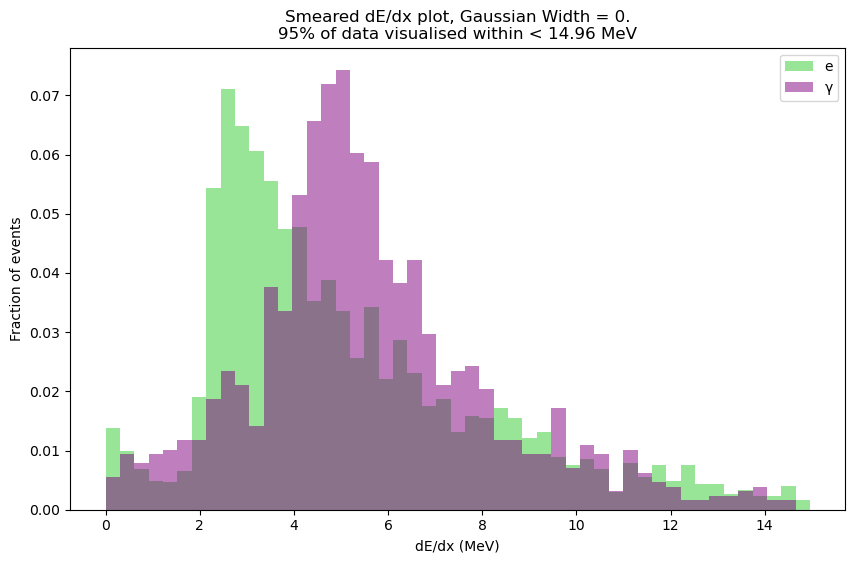

In [14]:
variables = dEdx_smear_histogram(cheated_0, showers_0, show_plot=True) # control

In [17]:
# Make some ROC curves of smeared dE/dx results.

def dEdx_ROC(events, idx_array, gauss_width_array): # gauss width array will be like [0, 0.5, 1, 1.5 ...], whatever you want to test.
    plt.figure(figsize = (8, 6))
    for w in gauss_width_array:
        if w > 0:
            e, gamma, thresholds, p95 = dEdx_smear_histogram(cheated_0, showers_0, gaussian_width=w)
    
            # Remove values above dEdx_cut
            e = e[e <= p95]
            gamma = gamma[gamma <= p95]
            
            total_e = len(e)  
            total_gamma = len(gamma)  
        
            FP_array = np.array([(e > t).sum() for t in thresholds[:-1]])
            TP_array = np.array([(gamma > t).sum() for t in thresholds[:-1]])
            
            efficiencies = TP_array / total_gamma
            purities = np.divide(TP_array, TP_array + FP_array, where=(TP_array + FP_array) > 0)
            plt.plot(efficiencies, purities, linewidth=2, label=f'\u03C3 = {w}', alpha=0.6)

    # control line
    e_0, gamma_0, thresholds_0, p95_0 = dEdx_smear_histogram(cheated_0, showers_0)
    e_0 = e_0[e_0 <= p95_0]
    gamma_0 = gamma_0[gamma_0 <= p95_0]
    
    total_e_0 = len(e_0)  
    total_gamma_0 = len(gamma_0)  

    TP_array_0 = np.array([(e_0 > t).sum() for t in thresholds_0[:-1]])
    FP_array_0 = np.array([(gamma_0 > t).sum() for t in thresholds_0[:-1]])
    
    efficiencies_0 = TP_array_0 / total_e_0
    purities_0 = np.divide(TP_array_0, TP_array_0 + FP_array_0, where=(TP_array_0 + FP_array_0) > 0)
    
    plt.plot(efficiencies_0, purities_0, linewidth=3, label='Control', c='r')
    plt.title('Efficiency/Purity ROC curves for Vertex Smeared dE/dx feature\nPositive selection: \u03B3')
    plt.xlabel('Efficiency (ε)')
    plt.ylabel('Purity (P)')
    plt.legend()
    plt.show()

In [21]:
dEdx_ROC(cheated_0, showers_0, [0.5, 1, 2, 5])

KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>